# 10장 시계열 데이터와 순환 신경망

**감사말**: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 10장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

**tensorflow 버전과 GPU 확인**
- 구글 코랩 설정: '런타임 -> 런타임 유형 변경' 메뉴에서 GPU 지정 후 아래 명령어 실행 결과 확인

    ```
    !nvidia-smi
    ```

- 사용되는 tensorflow 버전 확인

    ```python
    import tensorflow as tf
    tf.__version__
    ```
- tensorflow가 GPU를 사용하는지 여부 확인

    ```python
    tf.config.list_physical_devices('GPU')
    ```

## 주요내용

- 시계열 데이터 머신러닝 과제 예제
- 순환신경망(RNN, recurrent neural network) 이해
- 온도 예측 RNN 모델 구현
- 고급 RNN 활용 패턴

## 10.1 시계열 데이터 예제

**시계열**(timeseries)은 일정 간격으로 측정된 값들로 이루어진 데이터이다. 

- 일일 단위 증시 가격
- 도시의 시간당 소비 전력
- 매장의 주별 판매량

시계열은 자연현상 및 사람들의 일상에서 쉽게 구할 수 있다.

- 지진 활동
- 물고기 개체수
- 지역 날씨
- 웹사이트 방문자수
- 국내총생산(GDP)

시계열과 관련된 대표적인 과제는 **예측**(forcasting)이다. 
예를 들어, 몇 시간 후의 소비 전력, 몇 달 후의 영업 이익, 며칠 뒤의 날씨 등을 예측하는 일이다. 
이외에 시계열과 관련된 과제는 다음과 같다.

- 분류(classification): 웹사이트 방문자의 활동 이력을 보고 사람인지 여부 판단
- 이벤트 탐지(event detection): 오디오 스트림 감시 도중 "Ok Google", "Hey Alexa", "시리야" 등 핫워드(hotword) 탐지
- 이상치 탐지(anomaly detection): 생산라인 중에 발생하는 특이현상, 회사 네트워크 상에 발생하는 특이 활동 등 탐지.
    비지도 학습 활용.

## 10.2 예제: 온도 예측

나머지 이야기는 24시간 이후의 온도를 예측하는 모델을 구현하는 것이다. 
적절한 모델 구현과정을 통해 기존에 사용했던 밀집 연결 모델, 합성곱 모델 등은 적절하지 않고 
시계열 데이터에 대한 새로운 접근방식을 사용하는 **순환 신경망**(recurrent neural network, RNN)이
훨씬 잘 작동함을 보게 될 것이다. 

### 데이터셋 준비

독일 예나(Jena)시에 위치한 막스-플랑크(Max-Planck) 생지화확(Biogeochemistry) 연구소가
수 년동안 온도, 기압, 풍향 등 14 종류의 기상 데이터를 10분 단위로 측정해서 수집한 데이터셋이다. 
원래 2003년부터 측정하였지만 여기서는 2009-2016년 데이터만 이용한다. 

**zip 파일 다운로드 및 압축풀기**

"jena_climate_2009_2016.csv" 파일이 생성된다.

In [1]:
if 'google.colab' in str(get_ipython()):
    !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
    !unzip jena_climate_2009_2016.csv.zip
else: 
    try: 
        import wget, zipfile
    except ModuleNotFoundError: 
        !pip install wget
        
    import wget, zipfile
    wget.download('https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip')
    with zipfile.ZipFile('jena_climate_2009_2016.csv.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

100% [........................................................................] 13565642 / 13565642

**예나(Jena) 날씨 데이터셋 살펴보기**

파일을 열어 줄(line) 단위로 쪼갠다.

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")

첫째 줄은 날짜와 시간 이외에 14개의 특성명이 쉼표(콤마)로 구분되어 있으며,
총 420,451개의 데이터를 포함한다.

In [3]:
header = lines[0].split(",")
lines = lines[1:]

In [4]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [5]:
print(len(lines))

420451


첫째 데이터는 2009년 1월 1일 0시 10분에 측정되었다.

In [6]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [7]:
lines[0].split(',')

['01.01.2009 00:10:00',
 '996.52',
 '-8.02',
 '265.40',
 '-8.90',
 '93.30',
 '3.33',
 '3.11',
 '0.22',
 '1.94',
 '3.12',
 '1307.75',
 '1.03',
 '1.75',
 '152.30']

2번 인덱스 항목이 섭씨 온도이다. 

In [8]:
lines[0].split(',')[2]

'-8.02'

**넘파이 어레이로 변환**

In [9]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]

    temperature[i] = values[1]    # i 번째 온도
    raw_data[i, :] = values[:]    # i 번째 데이터

**온도 변화 그래프**

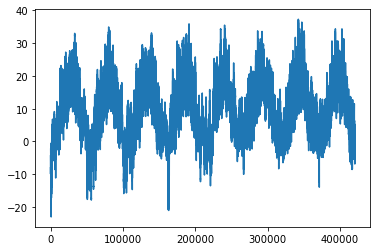

In [10]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

**처음 10일동안의 온도 변화**

한 시간에 6번, 하루 24시간, 10일동안 측정 횟수는 `6 * 24 * 10 = 1,440`이다.

- 1월 1일 - 1월 10일 기간동안 측정된 온도라 상당히 낮다.
- 마지막 4일 동안은 일 단위 온도 변화가 주기성을 띈다. 

**주기성**(periodicity)은 시계열 데이터의 기본 특성 중 하나이다.
월별 주기성은 매우 일관성을 갖는다. 
지난 몇 달동안의 데이터를 이용하여 다음 달의 평균 온도를 예측하는 일은 상대적으로 쉽다.
반면에 일 단위의 예측은 아래 그래프에서 보듯이 훨씬 혼잡하다. 

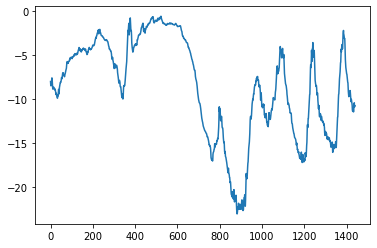

In [11]:
plt.plot(range(1440), temperature[:1440])

**훈련셋, 검증셋, 테스트셋 크기**

- 훈련셋: 전체의 50%
- 검증셋: 전체의 25%
- 테스트셋: 전체의 25%

미래에 대한 예측을 실행하므로 훈련셋, 검증셋, 테스트셋 순으로 
보다 오래된 데이터를 사용한다. 

In [12]:
num_train_samples = int(0.5 * len(raw_data))     # 전체의 50%
num_val_samples   = int(0.25 * len(raw_data))    # 전체의 25%
num_test_samples  = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:\t", num_train_samples)
print("num_val_samples:\t", num_val_samples)
print("num_test_samples:\t", num_test_samples)

num_train_samples:	 210225
num_val_samples:	 105112
num_test_samples:	 105114


### 데이터 전처리

시계열 데이터를 전처리 하려면 해결해야 할 문제를 명확히 지정해야 한다.
여기서는 지난 5일치의 날씨 데이터를 이용하여 앞으로 24시간 후의 온도를 예측하는 모델을 구현하고자 한다.
따라서 이 목적을 위한 시계열 데이터의 입력 샘플은 지난 5일치의 날씨 데이터를 하나의 시퀀스로 묶은 데이터이고,
타깃은 해당 시퀀스보다 24시간 앞선 데이터의 온도이어야 한다. 

5일 단위의 시퀀스와 타깃을 정하기 전에 먼저 기존 데이터셋을 정규화 한다.
즉, 특성별로 평균은 0, 표준편차는 1로 변환한다.

**주의사항**: 훈련셋의 평균값과 표준편차를 이용하여 모든 데이터셋을 정규화해야 한다.
앞서 언급한 것처럼 시계열 데이터의 훈련셋은 이른 시점에서의 데이터를 활용한다.

**데이터 정규화**

In [13]:
# 훈련셋의 평균
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

# 훈련셋의 표준편차
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**5일 단위 시퀀스 데이터 준비**

앞서 언급한 문제의 해결을 위한 모델을 구현하려면
5일 단위 시퀀스 데이터를 준비해야 하지만
`timeseries_dataset_from_array()` 함수를 활용하면 아주 쉽게 해결된다.
함수에 사용된 인자의 역할은 다음과 같다.

- `data`: 선택 대상 데이터셋 전체
- `targets`: 선택 대상 데이터셋 전체
- `sampling_rate`: 표본 비율. 몇 개 중에 하나를 선택할 것인지 지정.
- `sequence_length`: 시퀀스 샘플 길이
- `shuffle=True`: 생성된 시퀀스들의 순서를 무작위하게 섞음.
- `batch_size`: 배치 크기. 생성된 시퀀스들을 배치로 묶음.
- `start_index`: 표본 추출 대상 시작 구간
- `end_index`: 표본 추출 대상 끝 구간

In [14]:
from tensorflow import keras

# 1시간에 하나의 데이터 선택
sampling_rate = 6

# 입력 데이터 시퀀스: 지난 5일치(120시간) 온도 데이터
sequence_length = 120

# 타깃 설정:24시간 이후의 온도. 지연(delay)을 6일치로 지정
delay = sampling_rate * (sequence_length + 24 - 1)

# 배치 크기
batch_size = 256

# 훈련셋
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, # 생성된 시퀀스들의 순서 무작위화
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

# 검증셋
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

# 테스트셋
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

생성된 새로운 데이터셋은 훈련셋의 샘플과 타깃을 함께 배치 단위로 묶여있다.
예를 들어, 훈련셋의 첫째 배치의 모양은 다음과 같다.

- 배치 크기: 256
- 시퀀스 샘플 모양: `(120, 14)`
    - 14개의 특성을 갖는 날씨 데이터 5일치

In [15]:
for samples, targets in train_dataset:
    print("샘플 모양:", samples.shape)
    print("타깃 모양:", targets.shape)
    break

샘플 모양: (256, 120, 14)
타깃 모양: (256,)


#### 참고: `timeseries_dataset_from_array()` 활용법

아래 코드는 넘파이 어레이를 이용하여 
`timeseries_dataset_from_array()` 함수의 작동법을 설명한다.

In [16]:
int_sequence = np.arange(10)
int_sequence

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

길이가 3인 시퀀스 샘플을 2개씩 묶은 배치 3개가 만들어진다. 

In [18]:
i = 0
for inputs, targets in dummy_dataset:
    print(f"배치 {i}:")
    print("  samples shape:", inputs.shape)
    print("  targets shape:", targets.shape)
    print()
    i += 1

배치 0:
  samples shape: (2, 3)
  targets shape: (2,)

배치 1:
  samples shape: (2, 3)
  targets shape: (2,)

배치 2:
  samples shape: (1, 3)
  targets shape: (1,)



배치 별 샘플과 타깃을 확인하면 다음과 같다.

In [19]:
i = 0
for inputs, targets in dummy_dataset:
    print(f"배치 {i}:")
    for i in range(inputs.shape[0]):
        print("  샘플:", [int(x) for x in inputs[i]], "  타깃:", int(targets[i]))
    
    print()
    i += 1

배치 0:
  샘플: [0, 1, 2]   타깃: 3
  샘플: [1, 2, 3]   타깃: 4

배치 2:
  샘플: [2, 3, 4]   타깃: 5
  샘플: [3, 4, 5]   타깃: 6

배치 2:
  샘플: [4, 5, 6]   타깃: 7



### 베이스라인 설정

모델 성능의 최저 기준선으로 24시간 후의 온도를 현재 온도로 예측하는 것을 사용한다.
즉, 내일 이 시간 온도가 현재 온도와 별 차이가 없다는 가정을 이용한다. 
그러면 검증셋과 테스트셋에 대한 평균절대오차는 각각 2.44와 2.62이다.

In [20]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]  # 원 데이터로 되돌리기
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증셋 평균절대오차(MAE): {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트셋 평균절대오차(MAE): {evaluate_naive_method(test_dataset):.2f}")

검증셋 평균절대오차(MAE): 2.44
테스트셋 평균절대오차(MAE): 2.62


### 밀집 연결 모델 성능

밀집층만을 사용하는 모델의 성능은 베이스라인과 비슷하게 나온다.

- 평균절대오차는 모델평가지표로 사용한다.
- 손실함수는 (미분가능한 함수인) 평균제곱근오차를 사용한다.
- 첫째 층으로 사용된 `Flatten`에 의해 시간 흐름에 대한 정보를 사실상 잃어버린다. 

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

# 모델 구성
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs) # 1차원 데이터로 변환하기
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]

# 모델 컴파일 및 실행
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# 최선 모델 활용
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 9s 9ms/step - loss: 12.2736 - mae: 2.7183 - val_loss: 10.8664 - val_mae: 2.6009
Epoch 2/10
819/819 [==============================] - 7s 9ms/step - loss: 9.0685 - mae: 2.3677 - val_loss: 9.8934 - val_mae: 2.4891
Epoch 3/10
819/819 [==============================] - 7s 9ms/step - loss: 8.3427 - mae: 2.2740 - val_loss: 10.3937 - val_mae: 2.5519
Epoch 4/10
819/819 [==============================] - 7s 9ms/step - loss: 7.8283 - mae: 2.2023 - val_loss: 10.3538 - val_mae: 2.5459
Epoch 5/10
819/819 [==============================] - 8s 9ms/step - loss: 7.4707 - mae: 2.1519 - val_loss: 10.5405 - val_mae: 2.5723
Epoch 6/10
819/819 [==============================] - 7s 9ms/step - loss: 7.2358 - mae: 2.1186 - val_loss: 11.3723 - val_mae: 2.6761
Epoch 7/10
819/819 [==============================] - 7s 9ms/step - loss: 7.0119 - mae: 2.0874 - val_loss: 11.4496 - val_mae: 2.6884
Epoch 8/10
819/819 [==============================] - 7s 9ms/step - l

학습과정을 그래프로 나타내면 다음과 같다.
진동에도 불구하고 베이스라인에 가까운 성능이 나오지만 
하루 사이에 온도가 그리 급격히 바뀌지 않는다는
베이스라인 모델에 사용된 직관이 활용된 것 같아 보이지는 않다.

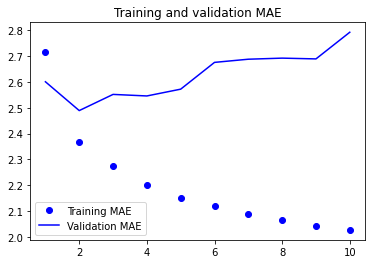

In [22]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 1D 합성곱 신경망 모델 성능

`Conv1D` 층은 `Conv2D` 층에서 사용된 필터 개념을 1차원 텐서에 대해 동일한
방식으로 적용한다. 
`MaxPooling1D` 층 또한 `MaxPooling2D`와 동일한 방식으로 작동한다.

아래 모델은 `Conv1D`와 `MaxPooling1D` 층을 이용한 합성곱 신경망 모델을
온도 예측에 활용한 결과를 보여준다.

- 첫 `Conv1D`에 사용된 필터의 크기는 24이다. 이유는 24시간 이후의 온도를 예측하기 때문이다. 
- 이후 `MaxPooling1D`를 사용하면서 동시에 필터의 크기도 절반씩 줄여 나간다. 

In [23]:
# 모델 구성
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]

# 모델 컴파일 및 실행
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# 최선 모델 활용
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 17s 12ms/step - loss: 22.5694 - mae: 3.7298 - val_loss: 15.5555 - val_mae: 3.1539
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 15.2617 - mae: 3.1021 - val_loss: 17.3005 - val_mae: 3.2850
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 13.7075 - mae: 2.9360 - val_loss: 19.5843 - val_mae: 3.4899
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 12.9298 - mae: 2.8494 - val_loss: 15.1198 - val_mae: 3.0507
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 12.3659 - mae: 2.7853 - val_loss: 16.3244 - val_mae: 3.1704
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 11.9325 - mae: 2.7334 - val_loss: 14.6759 - val_mae: 3.0422
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 11.5099 - mae: 2.6869 - val_loss: 14.5416 - val_mae: 3.0241
Epoch 8/10
819/819 [==============================] - 

학습과정을 그래프로 나타내면
매우 실망스러운 결과를 확인하게 된다.

- 날씨 데이터는 이미지 데이터와는 달리 위치 독립적이지 않다.
    실제로 시간대에 따라 동일한 패턴이 다른 의미를 가질 수 있다.
- 날씨 데이터는 시간의 흐름에 민감하다. 오래된 데이터보다 최근 데이터가 보다 예측에 중요하다.
    하지만 `Conv1D` 층은 이런 점을 활용하지 못한다. 

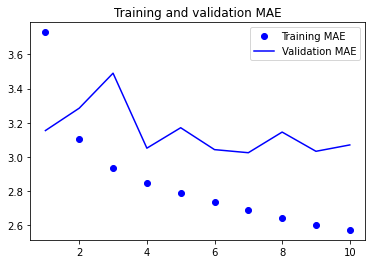

In [24]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 간단한 순환 모델 성능

가장 간단한 순환 신경망 모델이더라도 베이스라인보다 좋은 성능을 보여준다는 것을 확인할 수 있다.

- LSTM (장단기 메모리, Long Short Term Memory) 층: 시간 순서, 원인과 결과의 관계를 고려함.

In [25]:
# 모델 구성
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# LSTM 층
x = layers.LSTM(16)(inputs)

# 출력층
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]

# 모델 컴파일 및 실행
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 17ms/step - loss: 41.4105 - mae: 4.6696 - val_loss: 12.3946 - val_mae: 2.6863
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 11.0485 - mae: 2.5860 - val_loss: 9.6549 - val_mae: 2.4154
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 9.9441 - mae: 2.4608 - val_loss: 9.7519 - val_mae: 2.4207
Epoch 4/10
819/819 [==============================] - 14s 16ms/step - loss: 9.5458 - mae: 2.4071 - val_loss: 9.4256 - val_mae: 2.3791
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 9.2322 - mae: 2.3655 - val_loss: 9.5067 - val_mae: 2.3857
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 8.9148 - mae: 2.3218 - val_loss: 9.6452 - val_mae: 2.4019
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 8.6313 - mae: 2.2886 - val_loss: 9.6782 - val_mae: 2.4281
Epoch 8/10
819/819 [==============================] - 13s 1

학습과정을 그래프로 나타내면 다음과 같으며, 드디어 베이스라인보다 (조금이나마) 
좋은 성능을 보인다. 

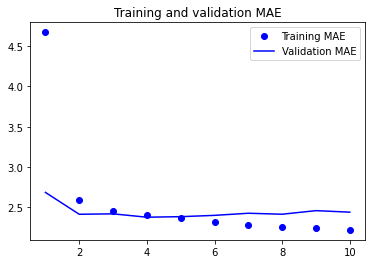

In [26]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 10.3 순환 신경망 이해

**순방향 신경망**

밀집 연결 모델은 시퀀스 샘플을 모두 풀어서 시퀀스 내의 순서를 무시한다.
합성곱 신경망 모델은 시퀀스 샘플을 통으로 하나의 값으로 처리하면서
시퀀스에 포함된 값들 사이의 순서 특성을 제대로 활용하지 못한다. 
즉, 두 모델 모두 모델에 입력된 이전 샘플의 정보를 이후 샘플이 전혀 활용하지 못하고,
하나의 샘플이 입력되면 바로 변환하고 다음 층으로 전달한다.
이런 이유로 밀집 연결 모델과 합성곱 신경망과 
같이 작동하는 모델을 **순방향 신경망**(feedforward network)라 부른다.

**순환 신경망(recurrent neural network)**

순환 신경망 모델은 시퀀스을 한 번에 처리하는 대신
포함된 항목들을 차례대로 처리할 때마다 얻은 정보를 바로 다음 층에
그대로 전달하지 않고 다음 항목을 처리할 때 함께 활용한다.
즉, 아래 그림이 보여주듯이 시퀀스 샘플을 항목에 대한 
일종의 반복작업(loop)으로 처리하며, 
하나의 항목을 처리할 때 이전 항목을 처리한 결과를 활용한다. 

시퀀스 항목을 하나 처리할 때마다 다음 항목에 활용되는 정보를 
**상태**(state)라 부른다.
상태는 하나의 시퀀스를 처리할 때마다 초기화되며,
이런 식으로 순환 신경망의 입력값은 시퀀스 샘플 단위로 처리된다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-06.png" style="width:25%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

### `SimpleRNN` 층 작동법

앞서 설명한 순환 신경망 아이디어를 가장 간단하게 구현한 모델이며 작동과정은 아래 그림과 같다. 

- `t`: 타임스텝(time step). 하나의 시퀀스에서 항목의 순서를 가리킴.
- `input_t`: 시퀀스의 `t` 번째 항목.
- `state_t`: 시퀀스의 `t-1` 번째 항목에 대한 출력값.
- `output_t`: `t` 번째 항목에 대한 출력값

        output_t = activation(dot(Wo, input_t) + dot(Uo, state_t) + bo)
        
- `Wo`, `Uo`, `bo`는 학습되어야 하는 파라미터들이다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/HighResolutionFigures/figure_10-7.png" style="width:80%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

### 케라스 순환층 기본 사용법

순환층은 임의의 길이의 시퀀스를 처리할 수 있다.

In [27]:
num_features = 14
inputs = keras.Input(shape=(None, num_features)) # 임의의 길이의 시퀀스 처리
outputs = layers.SimpleRNN(16)(inputs)

하지만 일정한 길이의 시퀀스만을 다룬다면 시퀀스 길이(steps)를 지정하는 것이 좋다.
이유는 모델을 구성한 후에 `summary()` 메서드를 활용하여
모델 훈련과정에 변환되는 텐서들의 모양을 정확히 추적할 수 있기 때문이다.

순환층의 출력값은 층 생성자의 `return_sequences` 키워드 인자의 값에 따라
시퀀스의 마지막 항목에 대한 출력값만 출력할지를 지정한다. 

- `return_sequences=False`인 경우: 시퀀스의 마지막 항목에 대한 출력값만 출력

In [28]:
num_features = 14  # 특성 수
steps = 120        # 시퀀스 길이 지정
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)  # 마지막 항목의 출력값만 사용
print(outputs.shape)

(None, 16)


- `return_sequences=True`인 경우: 시퀀스의 모든 항목에 대한 출력값을 출력

In [29]:
num_features = 14  # 특성 수
steps = 120        # 시퀀스 길이 지정
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)  # 모든 항목의 출력값 사용
print(outputs.shape)

(None, 120, 16)


순환층 또한 스택으로 쌓을 수 있다.
- 마지막 순환층을 제외한 모든 순환층은 `return_sequences=True`로 설정해야 함.

In [30]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

### `LSTM` 층 작동법

`SimpleRNN` 층은 실전에서 거의 사용되지 않는다.
이유는 이론과는 달리 시퀀스 내의 초기 상태(state)가 제대로 전달되지 않기 때문이다.
이 또한 역전파 과정에서 그레이디언트 소실이 발생하기 때문이다.
이에 대한 해결책으로 잔차 연결과 유사한 아이디어가 적용된
**LSTM**(Long Short Term Memory) 층이 1997년에 제시되었다. 

LSTM 층은 아래 그림에서 보듯이 장단기 메모리 모두 항목의 훈련에 활용된다. 

- `c_t`: 장기 메모리(carry)
- `state_t`: 단기 메모리
- `output_t`: `t` 번째 항목에 대한 출력값

        output_t = activation(dot(Wo, input_t) + dot(Uo, state_t) + dot(Vo, c_t) + bo)
        
        c_{t+1} = i_t * k_t + c_t * f_t
        
        i_t = activation(dot(Ui, state_t) + dot(Wi, input_t) + bi)
        f_t = activation(dot(Uf, state_t) + dot(Wf, input_t) + bf)
        k_t = activation(dot(Uk, state_t) + dot(Wk, input_t) + bk)        
        
- `Wo`, `Uo`, `Vo`, `bo`, `Wi`, `Ui`, `bi`, `Wf`, `Uf`, `bf`,
    `Wk`, `Uk`, `bk` 는 학습되어야 하는 파라미터들이다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-10.png" style="width:80%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

**참고**: `c_t` 계산에 사용되는 값들의 의미와 기능 확정적이지 않기에
세세한 내용 보다는 장단기 메모리가 순환층에서 어떻게 활용되는가에 대한 기본적인 이해가 중요하다.

## 10.4 순환 신경망 고급 활용법

순환 신경망의 성능을 끌어 올리는 세 가지 기법을 소개한다. 

- 순환 드랍아웃(recurrent dropout) 적용
- 순환층 쌓기
- 양방향 순환층(bidirectional recurrent layer) 활용

### 순환 드랍아웃 적용

앞서 한 개의 LSTM 층을 사용한 모델 훈련은 매우 빠르게 과대적합이 발생했다.
과대적합 발생을 늦추기 위해 드랍아웃 기법을 순환층에 대해서도 효율적으로 적용할 수 
있음이 2016년에 밝혀졌다. 

- 매 타임스텝에 대해 동일한 드랍아웃 마스크 적용
- 두 종류의 드랍아웃 옵션 사용
    - `dropout`: 층의 입력값에 대한 드랍아웃 비율 지정
    - `recurrent_dropout`: 순환 유닛에 대한 드랍아웃 비율 지정

아래 코드는 LSTM 층에 `recurrent_dropout=0.25` 옵션을 사용해서 모델을 훈련한다.

- 드랍아웃을 사용하기에 층의 유닛 수를 이전보다 두 배 늘림.
- 과대적합이 보다 늦게 발생할 것을 대비해 에포크 수를 50으로 늘림.

**주의사항**: 아래 코드를 실행하면 이전보다 훈련시간이 훨씬 오래 걸린다. 
단순히 에포크 수가 늘어나서가 아니라 하나의 에포크에 걸리는 시간이 몇 십배 느려진다.
이유는 드랍아웃을 사용하는 LSTM, GRU 모델은 cuDNN에서 제대로 지원되지 않는다.
이유는 순환층에 사용되는 `for` 반복문이 기본 설정에 대해서만 최적화되었기 때문이다.
기타 옵션을 사용하는 경우 `unroll=True` 옵션을 사용하면 
제한적(타임스텝이 100 이하로 지정된 경우)으로 cuDNN을 잘 활용할 수 있다. 
사용법은 다음과 같다. 

```python
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)
```

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

학습과정을 그래프로 나타내면 다음과 같으며, 과대적합이 20 에포크 이후에 
발생함을 확인할 수 있다.
동시에 모델의 성능도 좋아졌다. 

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-11.png" style="width:55%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

### 순환층 쌓기

순환층으로 스택으로 쌓아서 활용할 수도 있다.
아래 모델은 LSTM의 변종이면서 좀 더 가벼운 GRU(Gated Recurrent Unit) 층을 사용한다.
마지막 순환층을 제외한 모든 순환층에서 `return_sequences=True` 옵션을 
지정해야 함에 주의해야 한다. 

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

학습과정을 그래프로 나타내면 다음과 같으며 모델의 성능이 좀 더 좋아졌다.
하지만 층을 더 이상 쌓는다고 해서 성능이 반드시 더 좋아진다는 보장은 없으며
오히려 나빠질 수도 있다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-12.png" style="width:55%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

### 양방향 RNN 적용

자연어 처리(NLP, Natural language processing) 등에서는 한쪽 방향으로 뿐만 아니라 
반대 방향으로 시퀀스의 타임스텝을 처리하는 과정을 동시에 진행하는
양방향 RNN(bidirectional RNN) 층이 매우 효율적으로 적용된다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-14.png" style="width:50%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

하지만 날씨 예측 등과 같이 시간의 순서가 결정적인 경우에는 별 도움되지 않음을
아래 코드를 통해 확인할 수 있다.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### _성능 최대한 끌어올리기_

모델의 성능을 끌어 올리는 기본적인 접근법은 다음과 같다.

- 층의 유닛 개수 및 드랍아웃 비율 조정
- RMSprop 등의 옵티마이저의 학습률 조정 및 다른 옵티마이저 활용
- 순환층 이후에 여러 개의 밀집층 적용
- 시퀀스 길이 조정, 샘플 선택 비율 조정 등 기타 특성 엔지니어링 시도.